In [1]:
# Importing Modules

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import pickle
import spotify_api as sp_api

In [2]:
%matplotlib inline

In [3]:
# Loading the audio features db

songs_db = pd.read_csv("Data/audiofeatures_db.csv", index_col=0)
songs_db

,artist,song_name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Kenneth James Gibson,To See You Drift,7aEoQYVBZ7aWnQjy3q4Hel,0.0628,0.2260,7.0,-17.907,0.0,0.0402,0.867,0.917000,0.1040,0.0308,64.818
1,Kenneth James Gibson,Disinclined To Vacate,3raLHswCLEJbVrSe4EPltK,0.1230,0.1740,8.0,-21.421,1.0,0.0365,0.712,0.887000,0.0877,0.1260,72.822
2,Kenneth James Gibson,Gone Too Soon,2tgExJWl6bbB4SEoWq83AZ,0.0652,0.2350,6.0,-18.712,1.0,0.0399,0.581,0.977000,0.0745,0.0390,74.513
3,Kenneth James Gibson,Her Flood Knocked Me To The Ground (But I Was ...,0cFvfLVTPDDegtSa0utcTi,0.2150,0.2390,1.0,-19.038,1.0,0.0343,0.545,0.884000,0.1070,0.0378,128.935
4,Kenneth James Gibson,Monoceros,3oGk0mkyKnWYjNiGHGeTPK,0.0982,0.2220,4.0,-16.015,0.0,0.0434,0.598,0.963000,0.1180,0.0273,90.412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58242,Antonio Pappano,"Andrea Chénier / Act 3: ""La mamma morta""",45EO4JXAFZTGn1ag7SxyBH,0.2070,0.0908,2.0,-17.909,1.0,0.0466,0.986,0.000414,0.0877,0.0364,75.746
58243,Antonio Pappano,Pini di Roma (The Pines of Rome): IV. I pini d...,5pTP1tOx9NFtLtD9lm3H6A,0.1760,0.1460,11.0,-16.362,1.0,0.0370,0.532,0.951000,0.1130,0.0992,119.730
58244,Antonio Pappano,"La Wally / Act 1: ""Ebben? Ne andrò lontana""",5M8C2ngck48gKeErllR4uK,0.2760,0.1410,4.0,-18.474,1.0,0.0434,0.986,0.010400,0.1090,0.0392,84.376
58245,Antonio Pappano,"Madama Butterfly / Act 2: ""Un bel dì vedremo""",2xnxEkKnKgoYbHiJa2xuVV,0.2740,0.0984,1.0,-17.253,1.0,0.0421,0.987,0.000717,0.0854,0.0783,84.006


# Building the Model

In [4]:
# Selecting the features

audiofeatures = songs_db.iloc[:, 3:]
audiofeatures

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.0628,0.2260,7.0,-17.907,0.0,0.0402,0.867,0.917000,0.1040,0.0308,64.818
1,0.1230,0.1740,8.0,-21.421,1.0,0.0365,0.712,0.887000,0.0877,0.1260,72.822
2,0.0652,0.2350,6.0,-18.712,1.0,0.0399,0.581,0.977000,0.0745,0.0390,74.513
3,0.2150,0.2390,1.0,-19.038,1.0,0.0343,0.545,0.884000,0.1070,0.0378,128.935
4,0.0982,0.2220,4.0,-16.015,0.0,0.0434,0.598,0.963000,0.1180,0.0273,90.412
...,...,...,...,...,...,...,...,...,...,...,...
58242,0.2070,0.0908,2.0,-17.909,1.0,0.0466,0.986,0.000414,0.0877,0.0364,75.746
58243,0.1760,0.1460,11.0,-16.362,1.0,0.0370,0.532,0.951000,0.1130,0.0992,119.730
58244,0.2760,0.1410,4.0,-18.474,1.0,0.0434,0.986,0.010400,0.1090,0.0392,84.376
58245,0.2740,0.0984,1.0,-17.253,1.0,0.0421,0.987,0.000717,0.0854,0.0783,84.006


In [6]:
# Scaling them

scaler = StandardScaler()
scaler.fit(audiofeatures)
X_scaled = scaler.transform(audiofeatures)
audiofeatures_scaled = pd.DataFrame(X_scaled, columns = audiofeatures.columns)
audiofeatures_scaled.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04,5.824700e+04
mean,-3.319547e-16,-1.235623e-16,2.716784e-16,-1.540783e-16,1.099835e-16,8.341135e-17,-9.277940e-17,-9.356927e-16,1.730446e-16,7.377121e-17,2.550252e-16
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-2.981892e+00,-2.092808e+00,-1.495290e+00,-6.238758e+00,-1.237978e+00,-9.439000e-01,-9.031834e-01,-6.663691e-01,-1.101290e+00,-1.662392e+00,-4.234963e+00
25%,-6.149659e-01,-7.374688e-01,-9.325552e-01,-3.644633e-01,-1.237978e+00,-4.616520e-01,-8.642988e-01,-6.663612e-01,-5.871251e-01,-8.627683e-01,-7.216583e-01
50%,1.549353e-01,2.184534e-01,-8.845295e-02,3.155356e-01,8.077691e-01,-3.368194e-01,-5.143126e-01,-6.593995e-01,-4.071831e-01,-6.314471e-02,8.514224e-02
75%,7.583714e-01,8.390895e-01,7.556493e-01,6.809023e-01,8.077691e-01,-3.196502e-02,9.460028e-01,7.332508e-01,2.454233e-01,8.149466e-01,4.601185e-01
max,2.168123e+00,1.473993e+00,1.599752e+00,1.795283e+00,8.077691e-01,1.165762e+01,1.805332e+00,2.189998e+00,5.162148e+00,2.055484e+00,4.475939e+00


In [7]:
# Clustering the songs with the audio features (n=8)

kmeans = KMeans(n_clusters=6
                   , random_state=0
                   , n_init=10
                   , tol=0
                   , algorithm="elkan"
                   , init="k-means++"
                   )

kmeans.fit(audiofeatures_scaled)

KMeans(algorithm='elkan', n_clusters=6, random_state=0, tol=0)

In [8]:
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [9]:
print(kmeans.n_iter_)

44


In [10]:
kmeans.inertia_

348615.2803467833

# Playing with the parameters

In [11]:

for n in range(5,51,5):
    
    kmeans = KMeans(n_clusters=8
                   , random_state=0
                   , n_init=n
                   , tol=0
                   , algorithm="elkan"
                   , init="k-means++"
                   )
    
    kmeans.fit(audiofeatures_scaled)
    
    print(f'The inertia fot the model with n_init = {n} is {kmeans.inertia_}')

The inertia fot the model with n_init = 5 is 313741.6136906443
The inertia fot the model with n_init = 10 is 313741.6136906443
The inertia fot the model with n_init = 15 is 313741.6136906443
The inertia fot the model with n_init = 20 is 313741.6136906443
The inertia fot the model with n_init = 25 is 313741.6136906443
The inertia fot the model with n_init = 30 is 313741.6136906443
The inertia fot the model with n_init = 35 is 313741.6136906443
The inertia fot the model with n_init = 40 is 313741.6136906443
The inertia fot the model with n_init = 45 is 313741.6107573643
The inertia fot the model with n_init = 50 is 313741.6107573643


In [12]:
kmeans.n_iter_

90

# Choosing n of Clusters

Training a K-Means model with 2 clusters!

Training a K-Means model with 3 clusters!

Training a K-Means model with 4 clusters!

Training a K-Means model with 5 clusters!

Training a K-Means model with 6 clusters!

Training a K-Means model with 7 clusters!

Training a K-Means model with 8 clusters!

Training a K-Means model with 9 clusters!

Training a K-Means model with 10 clusters!

Training a K-Means model with 11 clusters!

Training a K-Means model with 12 clusters!

Training a K-Means model with 13 clusters!

Training a K-Means model with 14 clusters!

Training a K-Means model with 15 clusters!

Training a K-Means model with 16 clusters!

Training a K-Means model with 17 clusters!

Training a K-Means model with 18 clusters!

Training a K-Means model with 19 clusters!

Training a K-Means model with 20 clusters!



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

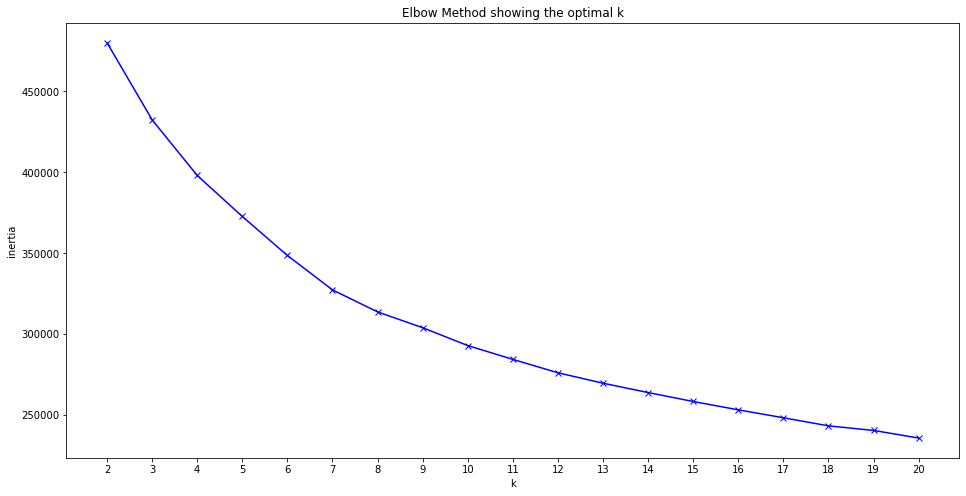

In [13]:
K = range(2, 21)
inertia = []

for k in K:
    
    print(f'Training a K-Means model with {k} clusters!')
    
    print()
    
    kmeans = KMeans(n_clusters=k
                   , random_state=0
                   , n_init=10
                   , tol=0
                   , algorithm="elkan"
                   , init="k-means++"
                   )
    
    kmeans.fit(audiofeatures_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

The curve is quite smooth, but seems that there is an optimal k in n=7

100%|██████████| 18/18 [09:30<00:00, 31.69s/it]


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

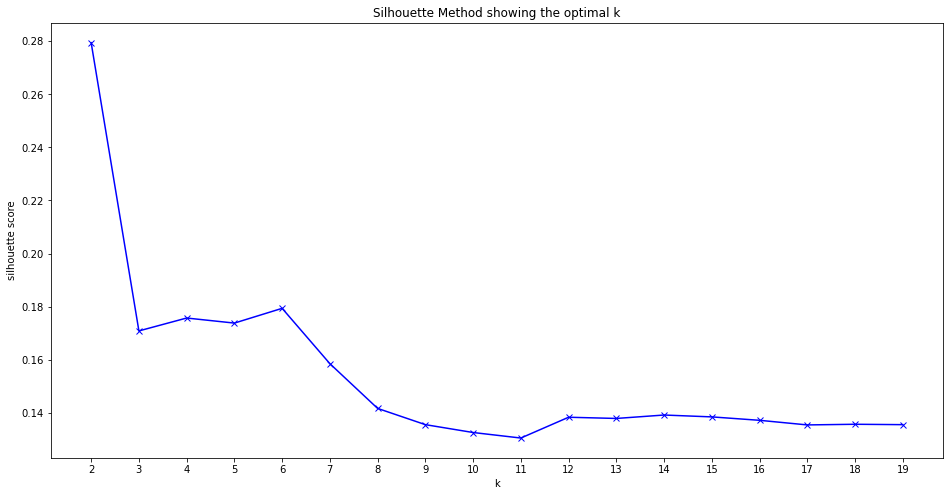

In [14]:
K = range(2, 20)
silhouette = []

for k in tqdm(K):
    
    kmeans = KMeans(n_clusters=k
                   , random_state=0
                   , n_init=10
                   , tol=0
                   , algorithm="elkan"
                   , init="k-means++"
                   )
    
    kmeans.fit(audiofeatures_scaled)
    
    silhouette.append(silhouette_score(audiofeatures_scaled, kmeans.predict(audiofeatures_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [45]:
user_song_id = sp_api.sp.search(q="in the end", type="track", limit=1, market="US")["tracks"]["items"][0]["id"]
user_song_id

'60a0Rd6pjrkxjPbaKzXjfq'

In [46]:
audio_f = sp_api.sp.audio_features(user_song_id)

In [47]:
row = []
audio_f_list = []

In [48]:
columns_names = ['danceability', 'energy', 'key', 'loudness',
                 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                 'valence', 'tempo'
                ]

In [49]:
for k in range(11):

    key = list(audio_f[0].keys())[k]
    audio_f_list.append(audio_f[0][key])

In [50]:
row.append(audio_f_list)
audio_f_df = pd.DataFrame(row, columns=columns_names)
X_scaled = scaler.transform(audio_f_df)
audio_f_scaled_df = pd.DataFrame(X_scaled, columns=columns_names)
audio_f_scaled_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-0.08956,0.988898,-0.651188,0.632801,-1.237978,-0.176508,-0.877134,-0.666369,0.163056,-0.167768,-0.540784


In [51]:
user_song_cluster = kmeans.predict(audio_f_scaled_df)

In [52]:
user_song_cluster

array([2])